In [1]:
#Importing the necessary libraries
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import sklearn
from sklearn.preprocessing import StandardScaler

In [2]:
# Calculating Cumulative Count Cut
def scaleCCC(x):
  return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x,2)))

def applyCCC(img):
  # Extracting individual bands(4,8,12) from the uploaded images
  band4 = img.GetRasterBand(1).ReadAsArray()
  band8 = img.GetRasterBand(2).ReadAsArray()
  band12 = img.GetRasterBand(3).ReadAsArray()
  ccc4 = scaleCCC(band4)
  ccc8 = scaleCCC(band8)
  ccc12 = scaleCCC(band12)
  # Creating a new image by combining the three bands
  return(np.dstack((ccc4,ccc8,ccc12)))

In [3]:
def process_image(img):
    # Read the image data as a NumPy array
    data = img.ReadAsArray()

    # Move the first axis (band dimension) to the last position
    data = np.moveaxis(data, 0, -1)

    # Get the shape of the data (number of rows, columns, and bands)
    rows, cols, bands = data.shape

    # Reshape the data from a 3D array to a 2D array (pixel samples x bands)
    data_2d = data.reshape(rows * cols, bands)

    # Scale the data using a scaler object (e.g., MinMaxScaler, StandardScaler, etc.)
    # The scaler object is assumed to have been previously defined or imported
    data_2d_scaled = scaler.fit_transform(data_2d)

    # Replace any NaN or infinite values with 0
    data_2d_scaled = np.nan_to_num(data_2d_scaled)

    # Return the scaled 2D data array
    return data_2d_scaled

In [4]:
# Defining Plot Function
def plot_image(plt_img):
  plt.figure()
  plt.imshow(plt_img)
  plt.show()

In [5]:
# Running the DBSCAN Algorithm
scaler = StandardScaler()
all_images=[]
first = True
first2 = True

for i in range(3,71):
    # List of images
    images_list=[str(i)+ "_P_256.tif", str(i) +"_A_256.tif"]
    images = []
    # Opening the satellite images
    for img_name in images_list:
        img = gdal.Open('./ALL_FLOOD_256/'+ img_name)
        data_2d_scaled = process_image(img)

        modified_img = applyCCC(img)
        images.append(modified_img)

        if(first):
            train_image=data_2d_scaled
            first = False
        else:
            train_image = np.concatenate([data_2d_scaled, train_image], axis=0)

    all_images.extend(images)
    if (first2):
        combined_data = train_image
    else:
        combined_data = np.concatenate([combined_data, train_image], axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


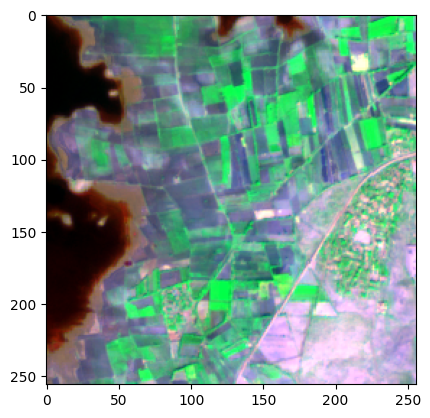

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


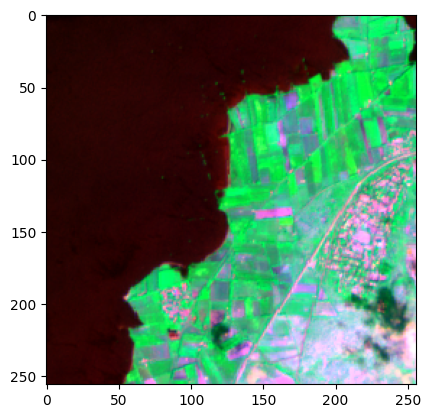

In [6]:
# Visualizing all the images
for img in images[:4]:
  plot_image(img)

In [7]:
#Running the GMM Algorithm
gmm_model = GaussianMixture(n_components = 2)
gmm_model = gmm_model.fit(combined_data)

In [8]:
# Opening the test images
imgP = gdal.Open("./ALL_FLOOD_256/2_P_256.tif")
imgA = gdal.Open("./ALL_FLOOD_256/2_A_256.tif")

before_img = applyCCC(imgP)
after_img = applyCCC(imgA)

X_before = process_image(imgP)
X_after = process_image(imgA)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


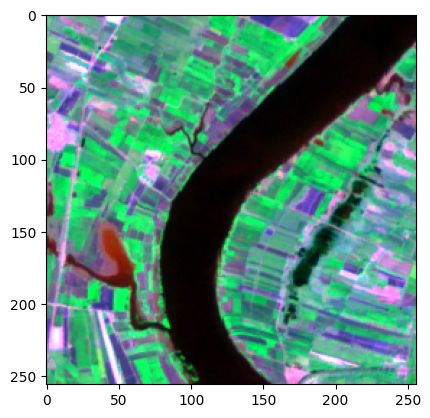

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


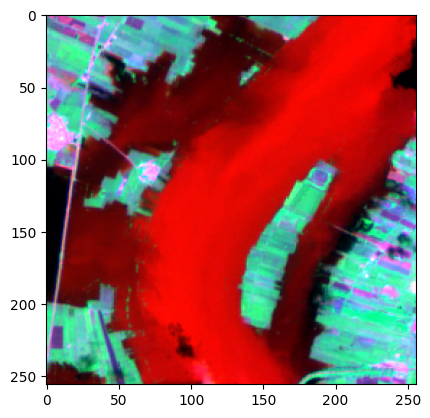

In [9]:
# Visualizing the before and after food images
plot_image(before_img)
plot_image(after_img)

In [10]:
# Running GMM Algorithm on test before image

gmm_before_labels = gmm_model.fit_predict(X_before)
gmm_before_labels_reshaped = gmm_before_labels.reshape(before_img[:, :, 0].shape)

In [11]:
# Running GMM Algorithm on test after image

gmm_after_labels = gmm_model.fit_predict(X_after)
gmm_after_labels_reshaped = gmm_after_labels.reshape(after_img[:, :, 0].shape)

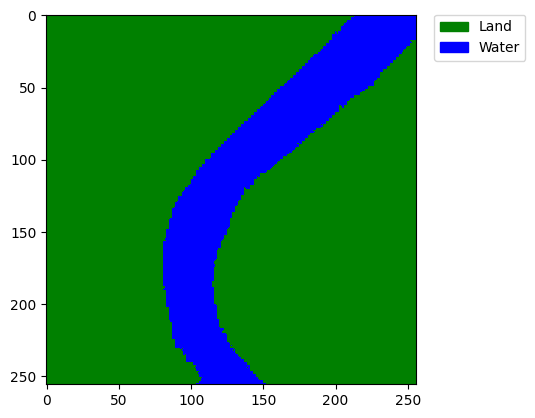

In [12]:
# Visualizing the clusters formed for pre-flood image

import matplotlib.patches as mpatches
import matplotlib.colors as colo

plt.figure()

custom = colo.ListedColormap(["green", "blue"])

im_before = plt.imshow(gmm_before_labels_reshaped, cmap = custom)

values = np.unique(gmm_before_labels_reshaped.ravel())

# Getting the colors of the values, according to the colormap used by imshow
colors = [im_before.cmap(im_before.norm(value)) for value in values]

# Creating a patch (proxy artist) for every color 
labels = ["Land", "Water"]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
# Putting those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

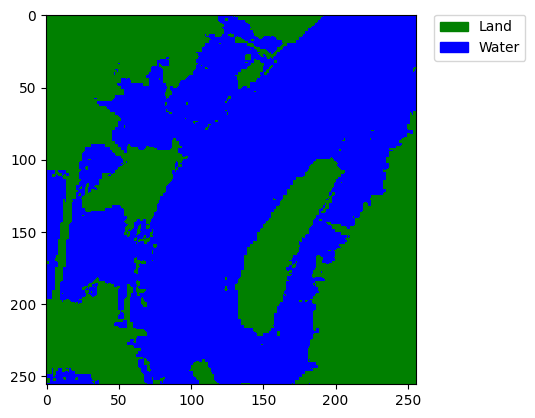

In [13]:
# Visualizing the clusters formed for post-flood image

plt.figure()

custom = colo.ListedColormap(["green", "blue"])

im_after = plt.imshow(gmm_after_labels_reshaped, cmap = custom)

values = np.unique(gmm_after_labels_reshaped.ravel())

# Getting the colors of the values, according to the colormap used by imshow
colors = [im_after.cmap(im_after.norm(value)) for value in values]

# Creating a patch (proxy artist) for every color 
labels = ["Land", "Water"]
patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
# Putting those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [14]:
# Calculating water percentage for before image

arr_before = np.unique(gmm_before_labels, return_counts=True)
key_before, val_before = arr_before
water_before = val_before[1]/sum(val_before) * 100
print("%.2f" %water_before, "%")

17.79 %


In [19]:
# Calculating water percentage for after image

arr_after = np.unique(gmm_after_labels, return_counts=True)
key_after, val_after = arr_after
water_after = val_after[1]/sum(val_after) * 100
print("%.2f" %water_after, "%")

56.65 %


In [20]:
# Calculating Flood Increase

flood_increase = water_after - water_before
print("%.2f" %flood_increase, "%")

38.86 %


In [18]:
# Calculating silhouette score for comparision

z = sklearn.metrics.silhouette_score(X_after, gmm_after_labels)
print("Accuracy:", ((z+1)/2)*100, "%")

Accuracy: 74.26555901765823 %
